In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ib_insync import *
import os
import sys

from optopus.ib_adapter import IBBrokerAdapter
from optopus.optopus import Optopus
from optopus.utils import to_df


%matplotlib inline
plt.style.use('dark_background')

2018-11-11 18:31:53,558 — optopus — INFO — Completed configuring the logger


http://conorsvensson.com/2014/11/24/volatility-cones-a-secret-weapon-in-options-trading/

In [2]:
# port = 7497 TWS paper trading
util.startLoop()
opt = Optopus(IBBrokerAdapter(IB(), host='127.0.0.1', port=7497, client=6))
opt.start()

2018-11-11 18:32:13,577 — optopus.optopus — INFO — System started


INFO:optopus.optopus:System started


# Market

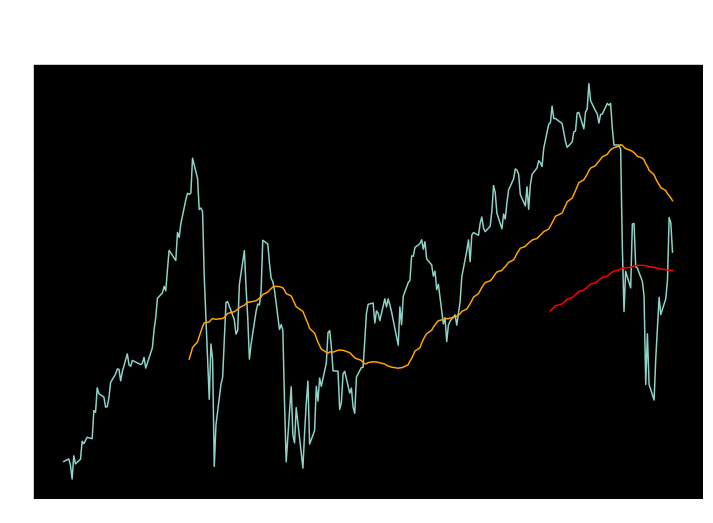

In [3]:
market_code='SPY'
time = opt.series(market_code, "time")
value = opt.series(market_code, "value")
sma50 = opt.series(market_code, "sma50")
sma200 = opt.series(market_code, "sma200")

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'MARKET ({market_code}')
ax.plot(time, value)
ax.plot(time, sma50, color='orange')
ax.plot(time, sma200, color='red')

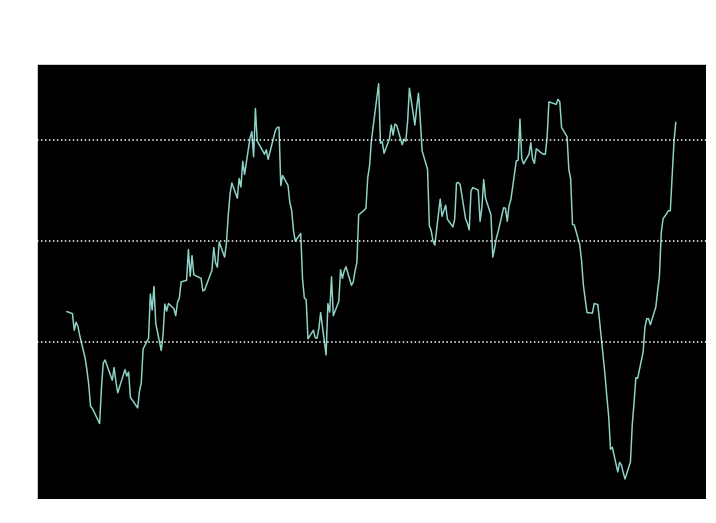

In [4]:
breadth_indicator='TRIN-NYSE'
time = opt.series(breadth_indicator, "time")
sma20 = opt.series(breadth_indicator, "sma20")

fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'BREADTH ({breadth_indicator})')
#ax.plot(time, value)
ax.plot(time, sma20)
ax.axhline(1.1, linestyle='dotted') # oversold

ax.axhline(1, linestyle='dotted')
ax.axhline(0.9, linestyle='dotted') #overbought


# Underlyings

In [5]:
df = to_df(opt.etfs.values())
df

,code,asset_type,currency,ask,ask_size,bid,bid_size,close,high,last,...,iv_pct,iv_percentile,iv_rank,price_pct,price_percentile,rsi,sma20,sma200,sma50,stdev
0,XLI,ETF,USD,-1.0,0,-1.0,0,73.16,NaN,NaN,...,-0.264128,0.861111,0.302715,-0.013486,0.289683,"(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.007195
1,OIH,ETF,USD,-1.0,0,-1.0,0,20.67,NaN,NaN,...,-0.102279,0.948413,0.267350,-0.156651,0.031746,"(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.016192
2,XOP,ETF,USD,-1.0,0,-1.0,0,36.41,NaN,NaN,...,0.040156,0.976190,0.475629,-0.104797,0.345238,"(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.016687
3,XLE,ETF,USD,-1.0,0,-1.0,0,68.62,NaN,NaN,...,-0.142144,0.940476,0.457203,-0.059066,0.277778,"(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.007764
4,SPY,ETF,USD,-1.0,0,-1.0,0,280.50,NaN,NaN,...,-0.326059,0.841270,0.277444,0.020539,0.773810,"(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0.004072


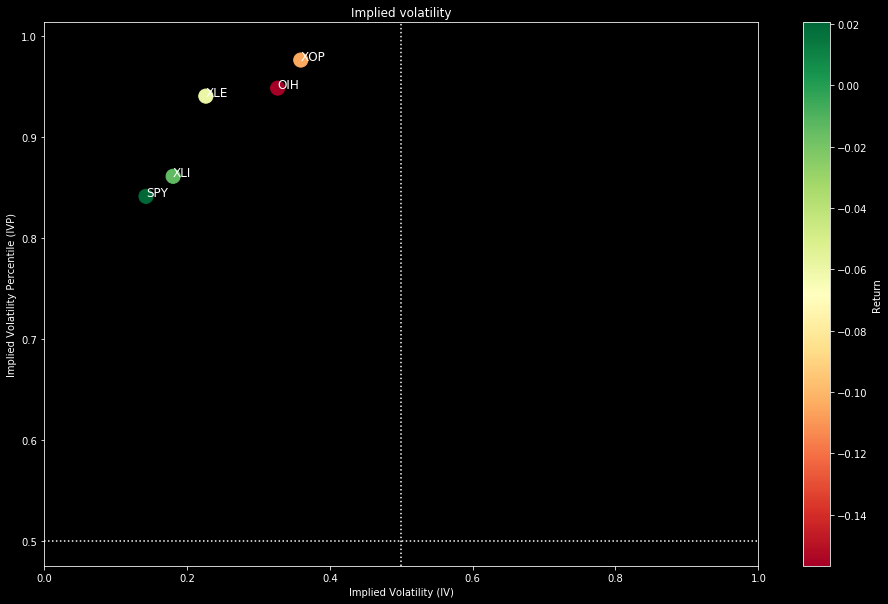

In [6]:
#ax = df.plot(kind='scatter', x='IV_h', y='IV_percentile_h', c='one_month_return', colormap='RdYlGn', s=200, figsize=(14,8))
plt.style.use('dark_background')
plt.figure(figsize=(16, 10))
sc = plt.scatter(x=df['iv'].values, y=df['iv_percentile'].values, c=df['price_pct'].values, cmap='RdYlGn', s=200)
plt.colorbar(sc).set_label('Return')
plt.title('Implied volatility')
plt.xlabel('Implied Volatility (IV)')
plt.ylabel('Implied Volatility Percentile (IVP)')
plt.xlim(0, 1)
plt.axvline(0.5, linestyle='dotted')
plt.axhline(0.5, linestyle='dotted')
for i, row in df.iterrows():
    #label = row['code'] + '({0:.2f} {1})'.format(row['price_pct'], row['directional_assumption'][0:2])
    label = f'{row["code"]}'
    plt.annotate(label, (row['iv'], row['iv_percentile']), fontsize=12)

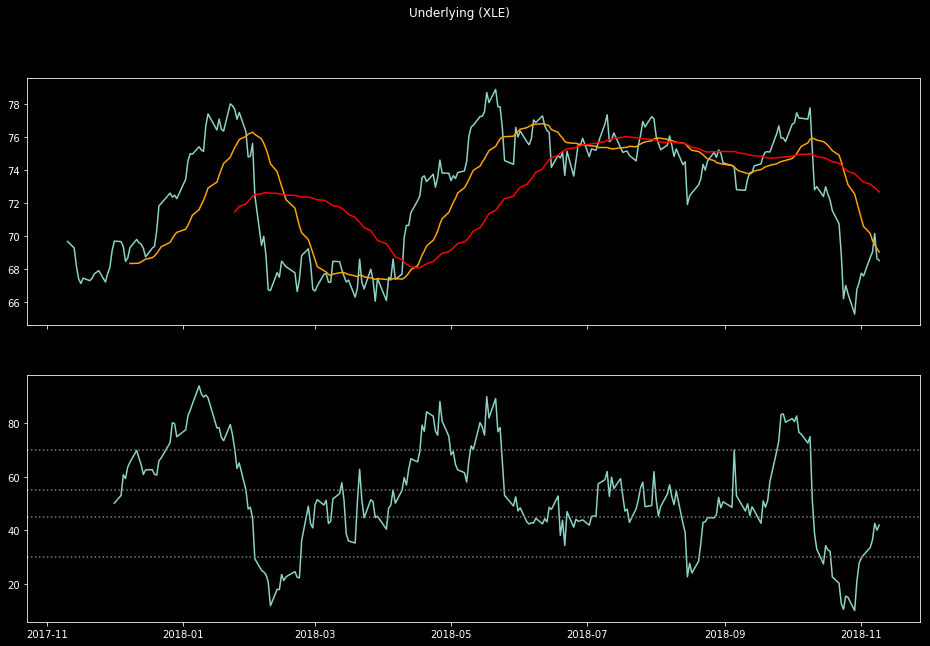

In [11]:
underlying_code='XLE'
time = opt.series(underlying_code, "time")
value = opt.series(underlying_code, "value")
sma20 = opt.series(underlying_code, "sma20")
sma50 = opt.series(underlying_code, "sma50")
rsi = opt.series(underlying_code, "rsi")

fig, ax = plt.subplots(2, sharex=True, figsize=(16, 10))
#fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle(f'Underlying ({underlying_code})')
ax[0].plot(time, value)
ax[0].plot(time, sma20, color='orange')
ax[0].plot(time, sma50, color='red')

ax[1].plot(time, rsi)
ax[1].axhline(70, linestyle='dotted', color='gray')
ax[1].axhline(30, linestyle='dotted', color='gray')
ax[1].axhline(55, linestyle='dotted', color='gray')
ax[1].axhline(45, linestyle='dotted', color='gray')

In [9]:
df[['code', 'correlation']].sort_values(['correlation'], ascending=False).style.background_gradient(cmap='RdYlGn')

,code,correlation
3,SPY,1
1,XLI,0.877857
2,XLE,0.689298
0,XOP,0.602153
4,OIH,0.562956


In [7]:
candidates = df[(df['iv_percentile'] > 0.8)  & (df['iv'] > 0.2) & (df['price_pct'] < -0.1)]
candidates[['code', 'iv_percentile', 'iv', 'iv_pct', 'price_pct', 'price_percentile', 'correlation', 'market_price', 'directional_assumption']].sort_values(['iv_percentile', 'iv'], ascending=[False, False])

,code,iv_percentile,iv,iv_pct,price_pct,price_percentile,correlation,market_price,directional_assumption


In [8]:
code='SPY'

In [9]:
price_bars = opt.price_history(code)

In [10]:
prices = [b.close for b in price_bars.values]
dates = [b.time for b in price_bars.values]

In [11]:
rsi= opt.rsi_history(code)
rsi_sma = opt.rsi_sma_history(code)
sma1 = opt.sma1_history(code)
sma2 = opt.sma2_history(code)

AttributeError: 'Measures' object has no attribute 'sma1'

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 10))
fig.suptitle('RSI')
ax1.plot(dates, prices)
ax2 = ax1.twinx()
ax2.plot(dates, rsi, linestyle='dotted', color='lightgray')
#ax2.plot(dates, rsi_sma, linestyle='dotted', color='gray')
ax1.plot(dates, sma1, color='yellow')
#ax4 = ax1.twinx()
ax1.plot(dates, sma2, color='pink')

ax2.axhline(70, linestyle='dotted', color='gray')
ax2.axhline(30, linestyle='dotted', color='gray')
ax2.axhline(55, linestyle='dotted', color='gray')
ax2.axhline(45, linestyle='dotted', color='gray')

In [ ]:
#f, ax = plt.subplots(2, sharex=True, figsize=(16, 10))
#f.suptitle('RSI')
#ax[0].plot(dates, prices)
#ax[1].plot(dates, rsi)
#ax[1].axhline(80, linestyle='dotted', color='red')
#ax[1].axhline(20, linestyle='dotted', color='red')